# Run orbitize on the in-house planet c astrometry

In [1]:
last_epoch = 5
total_orbits = 40000

In [2]:
import numpy as np
import os
import multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt

import astropy.io.ascii
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

#import astroquery.simbad

import orbitize
from orbitize import driver

import pandas as pd

#plt.style.use('dark_background')
plt.style.use('bmh')
matplotlib.rcParams['font.size'] = 16

In [3]:
print(orbitize.__version__)

1.12.1


In [4]:
print(astropy.__version__)

4.1


In [5]:
#data_dir = os.getcwd()
data_dir = os.path.relpath("./results/")

print(data_dir)
#%ls

results


### Select either perfect or noisy measured astrometry (True / False)

In [6]:
perfect_data = False

### Select observing epochs to fit

In [7]:
use_epoch_inds = np.arange(last_epoch)
num_epochs = len(use_epoch_inds)
print(use_epoch_inds)

[0 1 2 3 4]


### Apply priors (True / False)

In [8]:
apply_RV_priors = True
apply_PAN_priors = True

### Load table of astrometry & photometry

In [9]:
planetc_meas_table_fname = os.path.join(data_dir, "planet_c_in-house.xlsx")
rel_astrom_table = astropy.table.Table()

if perfect_data:
    planetc_meas = pd.read_excel(planetc_meas_table_fname, sheet_name="truth", header=1)
    
    dates = planetc_meas['date (JD)'][use_epoch_inds].values
    raoffs = -planetc_meas['delta x (mas)'][use_epoch_inds].values # sign flip for reversed RA axis
    decoffs = planetc_meas['delta y (mas)'][use_epoch_inds].values
    raoff_errs = 5 * np.ones([len(dates)]) # assume nominal 5 mas errors
    decoff_errs = raoff_errs
else:
    planetc_meas = pd.read_excel(planetc_meas_table_fname, sheet_name="reduced", header=1)

    dates = planetc_meas['date (JD)'][use_epoch_inds].values
    raoffs = planetc_meas['RA offset (mas)'][use_epoch_inds].values
    decoffs = planetc_meas['Dec offset (mas)'][use_epoch_inds].values
    raoff_errs = planetc_meas['astrometric uncertainty (mas per axis)'][use_epoch_inds].values
    decoff_errs = raoff_errs

### Format data for orbitize

In [10]:
epoch_col = astropy.table.Table.Column(name = 'epoch', data = dates, dtype = float)
object_col = astropy.table.Table.Column(name = 'object', data = np.ones([len(dates)]), dtype = int)
raoff_col = astropy.table.Table.Column(name = 'raoff', data = raoffs, dtype = float)
raoff_err_col = astropy.table.Table.Column(name = 'raoff_err', data = raoff_errs, dtype = float)
decoff_col = astropy.table.Table.Column(name = 'decoff', data = decoffs, dtype = float)
decoff_err_col = astropy.table.Table.Column(name = 'decoff_err', data = decoff_errs, dtype = float)

rel_astrom_table.add_column(epoch_col, index = 0)
rel_astrom_table.add_column(object_col, index = 1)
rel_astrom_table.add_column(raoff_col, index = 2)
rel_astrom_table.add_column(raoff_err_col, index = 3)
rel_astrom_table.add_column(decoff_col, index = 4)
rel_astrom_table.add_column(decoff_err_col, index = 5)

In [11]:
rel_astrom_table

epoch,object,raoff,raoff_err,decoff,decoff_err
float64,int64,float64,float64,float64,float64
2461345.5,1,129.39894929768937,5.7,108.99372972926345,5.7
2461400.29,1,143.11938498375255,6.8,78.46890609302946,6.8
2461710.75,1,227.90000000000006,3.94,-82.79999999999988,3.94
2462076.0,1,209.29825799999998,8.9,-245.43609000000004,8.9
2462441.25,1,84.32160000000002,20.8,-252.96479999999997,20.8


/Users/nzimmerm/anaconda3/envs/DC_nbtest/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Dec offset')

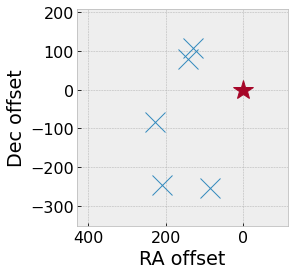

In [12]:
plt.figure(figsize=(5,4))
plt.plot(rel_astrom_table['raoff'], rel_astrom_table['decoff'], 'x', markersize=20)
plt.plot(0, 0, '*', markersize=20)
plt.axes().set_aspect('equal') 
plt.xlim([np.max(rel_astrom_table['raoff']) + 200, np.min(rel_astrom_table['raoff']) - 200])
plt.ylim([np.min(rel_astrom_table['decoff']) - 100, np.max(rel_astrom_table['decoff']) + 100])
plt.xlabel('RA offset')
plt.ylabel('Dec offset')

In [13]:
if perfect_data:
    rel_astrom_orbitize_table_filename = os.path.join(data_dir, "planetc_truth_{:d}epochs_orbitize.csv".format(num_epochs))
else:
    rel_astrom_orbitize_table_filename = os.path.join(data_dir, "planetc_in-house-meas_{:d}epochs_orbitize.csv".format(num_epochs))

print(rel_astrom_orbitize_table_filename)

results/planetc_in-house-meas_5epochs_orbitize.csv


In [14]:
orbitize.read_input.write_orbitize_input(rel_astrom_table,
                                         rel_astrom_orbitize_table_filename,
                                         file_type = 'csv')

In [15]:
%ls *.csv

ls: *.csv: No such file or directory


### Star parameters

In [16]:
star_name = "47 UMa"

#customSimbad = astroquery.simbad.Simbad()
#customSimbad.add_votable_fields('plx', 'plx_error')
#simbad_table = customSimbad.query_object(star_name)
#plx = simbad_table['PLX_VALUE'][0]
#plx_err = simbad_table['PLX_ERROR'][0]

plx = 72.4528
plx_err = 0.1507

print(plx, plx_err)

72.4528 0.1507


### Initialize orbitize model

In [17]:
# system parameters
num_secondary_bodies = 1
system_mass = 1 # [Msol]
mass_err = 0.05 # [Msol]

data_table = orbitize.read_input.read_file(rel_astrom_orbitize_table_filename)

sys = orbitize.system.System(num_secondary_bodies,
                             data_table,
                             system_mass,
                             plx,
                             mass_err=mass_err,
                             plx_err=plx_err)

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.

Converting input epochs from JD to MJD.



### Configure priors

In [18]:
if apply_RV_priors:
    # Radvel constrains the period of the planet, but it tends to underestimates its uncertainty;
    # we set a conservative prior that covers a wider range than the radvel posterior.
    P_min = 3000 * u.day
    P_max = 3500 * u.day
    sma_min = ((P_min ** 2 * c.G * system_mass * u.M_sun / (4 * np.pi ** 2)) ** (1./3)).to(u.AU)
    sma_max = ((P_max ** 2 * c.G * system_mass * u.M_sun / (4 * np.pi ** 2)) ** (1./3)).to(u.AU)

    # Radvel constrains the inclination to be less than 0.2 with high confidence.  
    ecc_min = 0.0
    ecc_max = 0.2

    # Radvel finds the argument of periapsis of the star's orbit to be approximately 260 deg;
    # by defintion, the argument of periastron of the planet is offset 180 deg,
    # so we sample this parameter in a +/- 75 deg neighborhood of 80 deg.
    aop_min = np.deg2rad(5.0)
    aop_max = np.deg2rad(155.0)
    
    sys.sys_priors[sys.param_idx['sma1']] = orbitize.priors.UniformPrior(sma_min.value, sma_max.value)
    sys.sys_priors[sys.param_idx['ecc1']] = orbitize.priors.UniformPrior(ecc_min, ecc_max)
    sys.sys_priors[sys.param_idx['aop1']] = orbitize.priors.UniformPrior(aop_min, aop_max)
    
if apply_PAN_priors:
    # The position angle of the ascending node can be constrained by the phase curve of the planet
    # to occur in the right-hand half of the sky plane (West of the star), so we restrict the 
    # position angle to the range 180 and 360 deg.
    pan_min = np.deg2rad(180.0)
    pan_max = np.deg2rad(360.0) 
    sys.sys_priors[sys.param_idx['pan1']] = orbitize.priors.UniformPrior(pan_min, pan_max)

In [19]:
sys.param_idx

{'sma1': 0,
 'ecc1': 1,
 'inc1': 2,
 'aop1': 3,
 'pan1': 4,
 'tau1': 5,
 'plx': 6,
 'mtot': 7}

In [20]:
sys.sys_priors

[Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Gaussian, Gaussian]

In [21]:
print(vars(sys.sys_priors[sys.param_idx['ecc1']]))

{'minval': 0.0, 'maxval': 0.2}


### Configure MCMC and run

In [22]:
# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

mcmc_sampler = orbitize.sampler.MCMC(sys, num_temps, num_walkers, num_threads)

burn_steps = 20 # steps to burn in per walker
thin = 2 # only save every 2nd step

_ = mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Users/nzimmerm/anaconda3/envs/DC_nbtest/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/Users/nzimmerm/anaconda3/envs/DC_nbtest/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/Users/nzimmerm/anaconda3/envs/DC_nbtest/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


/Users/nzimmerm/anaconda3/envs/DC_nbtest/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)


Burn in complete


40/40 steps completed
Run complete


Text(0, 0.5, 'number of orbits')

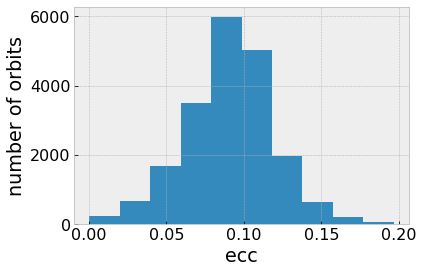

In [23]:
accepted_eccentricities = mcmc_sampler.results.post[:, sys.param_idx['ecc1']]
plt.hist(accepted_eccentricities)
plt.xlabel('ecc'); plt.ylabel('number of orbits')

In [24]:
#help(mcmc_sampler.results.plot_corner())

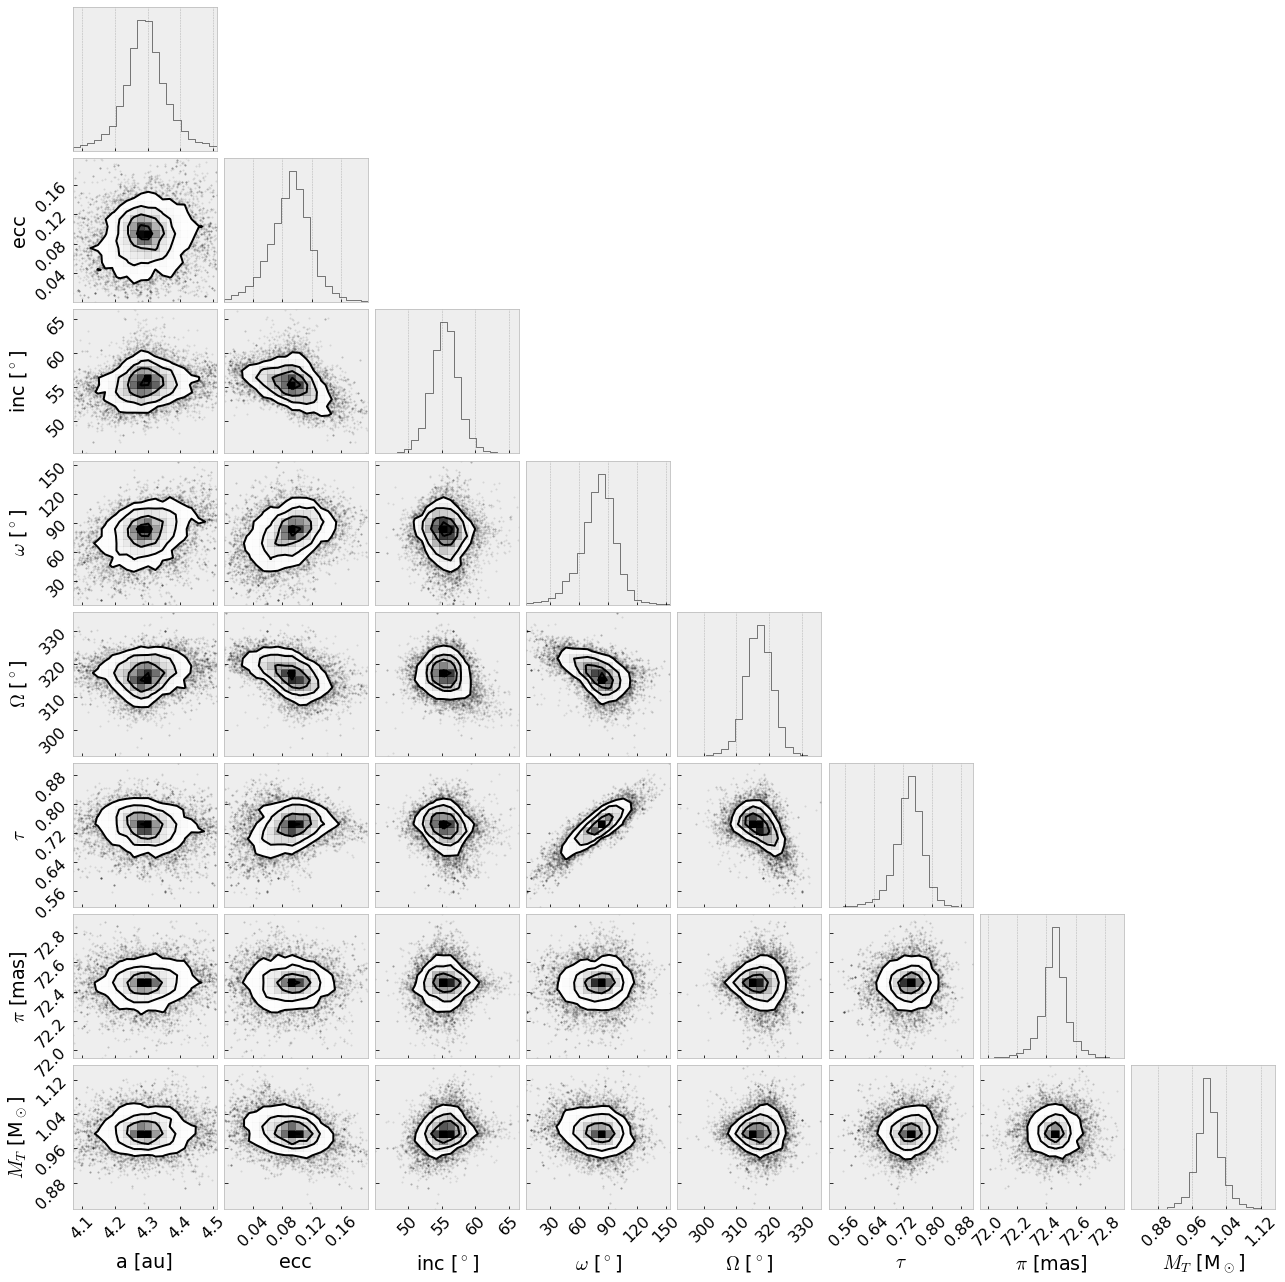

In [25]:
plt.style.use('bmh')
corner_figure = mcmc_sampler.results.plot_corner()

#### Semi-major axis

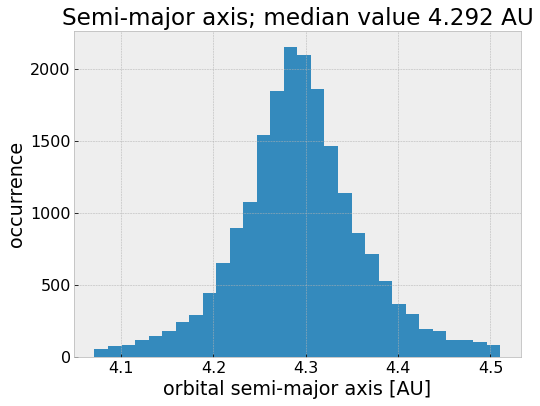

In [26]:
sma = [x[sys.param_idx['sma1']] for x in mcmc_sampler.results.post]

plt.figure(figsize=(8,6))
# Use this histogram if SMA is poorly constrained:
#plt.hist(sma, range = [0, 10], bins=30)
# Use this histogram if SMA is well constrained:
plt.hist(sma, bins=30)

plt.title('Semi-major axis; median value {:.3f} AU'.format(np.median(sma)))
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurrence')
plt.show()

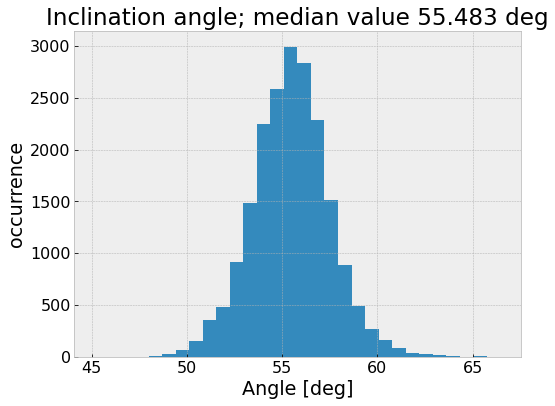

In [27]:
inc = np.rad2deg([x[sys.param_idx['inc1']] for x in mcmc_sampler.results.post])

plt.figure(figsize=(8,6))
plt.hist(inc, bins=30)
plt.title('Inclination angle; median value {:.3f} deg'.format(np.median(inc)))
plt.xlabel('Angle [deg]')
plt.ylabel('occurrence')
plt.show()

#### Eccentricity

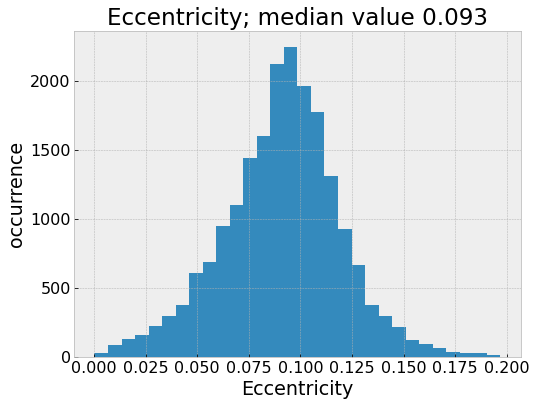

In [28]:
ecc = [x[sys.param_idx['ecc1']] for x in mcmc_sampler.results.post]

plt.figure(figsize=(8,6))
plt.hist(ecc, bins=30)
plt.title('Eccentricity; median value {:.3f}'.format(np.median(ecc)))
plt.xlabel('Eccentricity')
plt.ylabel('occurrence')
plt.show()

#### Position angle of nodes

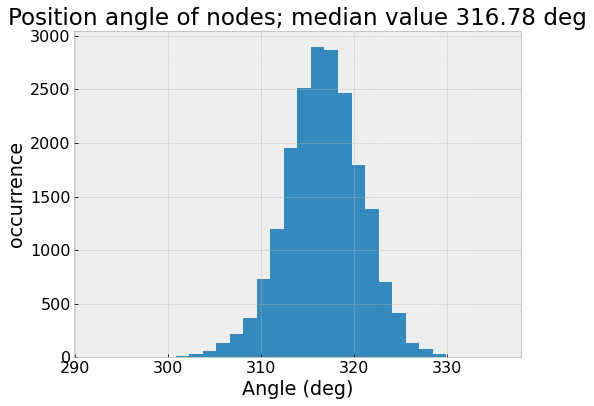

316.78396517984277


In [29]:
pan = np.rad2deg([x[sys.param_idx['pan1']] for x in mcmc_sampler.results.post])

plt.figure(figsize=(8,6))
plt.hist(pan, bins=30)
plt.title('Position angle of nodes; median value {:.2f} deg'.format(np.median(pan)))
plt.xlabel('Angle (deg)')
plt.ylabel('occurrence')
plt.show()

print(np.median(pan))

#### Argument of periastron

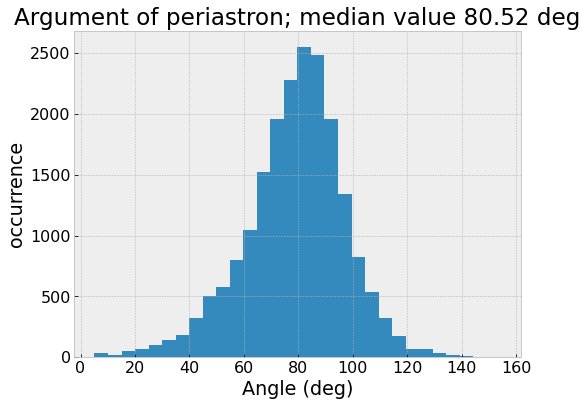

80.52232275400885


In [30]:
aop = np.rad2deg([x[sys.param_idx['aop1']] for x in mcmc_sampler.results.post])

plt.figure(figsize=(8,6))
plt.hist(aop, bins=30)
plt.title('Argument of periastron; median value {:.2f} deg'.format(np.median(aop)))
plt.xlabel('Angle (deg)')
plt.ylabel('occurrence')
plt.show()

print(np.median(aop))

#### Periastron passage

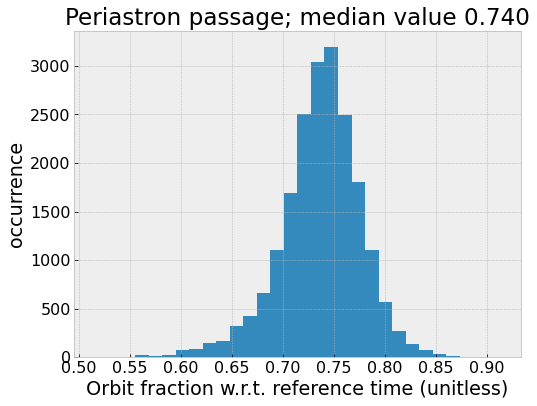

In [31]:
tau = np.array([x[sys.param_idx['tau1']] for x in mcmc_sampler.results.post])

plt.figure(figsize=(8,6))
plt.hist(tau, bins=30)
plt.title('Periastron passage; median value {:.3f}'.format(np.median(tau)))
plt.xlabel('Orbit fraction w.r.t. reference time (unitless)')
plt.ylabel('occurrence')
plt.show()

### Show correlation between periastron time and argument of periastron

Text(0, 0.5, '$\\tau$')

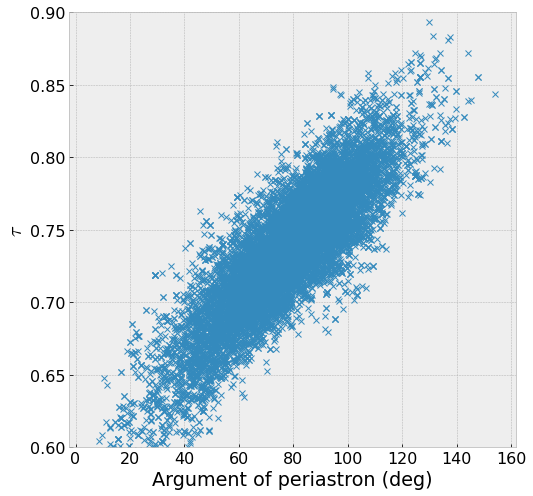

In [32]:
plt.figure(figsize=(8,8))

plt.plot(aop, tau, 'x')

#plt.xlim([200, 340])
plt.ylim([0.6, 0.9])

plt.xlabel('Argument of periastron (deg)')
plt.ylabel(r'$\tau$', size=20)

### Summary of MCMC results

In [33]:
mtot = [x[sys.param_idx['mtot']] for x in mcmc_sampler.results.post]

median_sma = np.median(sma) * u.AU
median_inc = np.median(inc) * u.deg
median_tau = np.median(tau)
median_aop = np.median(aop) * u.deg
median_mtot = np.median(mtot) * u.M_sun
median_period = np.sqrt( 4 * np.pi**2 / (c.G * median_mtot)
                        * median_sma**3 ).to(u.day)

print('SMA = {:.3f}'.format(median_sma))
print('inc = {:.2f}'.format(median_inc))
print('AOP = {:.2f}'.format(median_aop))
print('tau = {:.4f}'.format(median_tau))
print('m_tot = {:.4f}'.format(median_mtot))
print('period = {:.2f}'.format(median_period))

SMA = 4.292 AU
inc = 55.48 deg
AOP = 80.52 deg
tau = 0.7398
m_tot = 0.9974 solMass
period = 3251.98 d


### Write table of planet properties

In [34]:
np.quantile(sma, [0.0225, 0.16, 0.5, 0.84, 0.9775])

array([4.14180685, 4.23221424, 4.29190229, 4.35558052, 4.45073016])

In [35]:
planetc_orbitize_result_table_fname = os.path.join(
        data_dir,
        "planet_c_in-house_orbitize_{:d}epochs_RVpriors{:}_totorb{:06d}.csv".format(
        num_epochs, apply_RV_priors, total_orbits))
planetc_orbitize_result_table = astropy.table.Table()

sma_col = astropy.table.Table.Column(name = 'sma',
                                     data = np.quantile(sma, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)
inc_col = astropy.table.Table.Column(name = 'inc',
                                     data = np.quantile(inc, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)
ecc_col = astropy.table.Table.Column(name = 'ecc',
                                     data = np.quantile(ecc, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)
tau_col = astropy.table.Table.Column(name = 'tau',
                                     data = np.quantile(tau, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)
aop_col = astropy.table.Table.Column(name = 'aop',
                                     data = np.quantile(aop, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)
pan_col = astropy.table.Table.Column(name = 'pan',
                                     data = np.quantile(pan, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)
mtot_col = astropy.table.Table.Column(name = 'mtot',
                                     data = np.quantile(mtot, [0.0225, 0.16, 0.5, 0.84, 0.9775]),
                                     dtype = float)

planetc_orbitize_result_table.add_column(sma_col, index = 0)
planetc_orbitize_result_table.add_column(inc_col, index = 1)
planetc_orbitize_result_table.add_column(ecc_col, index = 2)
planetc_orbitize_result_table.add_column(tau_col, index = 3)
planetc_orbitize_result_table.add_column(aop_col, index = 4)
planetc_orbitize_result_table.add_column(pan_col, index = 5)
planetc_orbitize_result_table.add_column(mtot_col, index = 6)

planetc_orbitize_result_table.write(planetc_orbitize_result_table_fname, overwrite=True)